### 1. Configuración y Carga de Datos

Para iniciar el análisis, establezco la conexión con la base de datos local PostgreSQL donde previamente se almacenaron los datos limpios. Utilizo la pandas para ejecutar una consultas SQL y cargar la información en un DataFrame.

In [179]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv

# Cargar las variables del archivo .env
load_dotenv()

# Configuración de credenciales de base de datos usando variables de entorno
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")

try:
    conn = psycopg2.connect(
        user=DB_USER,
        password=DB_PASS,
        host=DB_HOST,
        port=5432,
        dbname=DB_NAME
    )

    # Extracción de todos los registros históricos ordenados por fecha
    query = "SELECT * FROM historico_precios_canasta ORDER BY fecha_registro DESC"
    df_canasta = pd.read_sql_query(query, conn)

    print(f"Datos cargados correctamente. Dimensiones del dataset: {df_canasta.shape}")

except Exception as e:
    print(f"Error en la conexión o consulta: {e}")

finally:
    if 'conn' in locals() and conn:
        conn.close()

C:\Users\JAM\AppData\Local\Temp\ipykernel_20052\515621498.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_canasta = pd.read_sql_query(query, conn)


Datos cargados correctamente. Dimensiones del dataset: (1325511, 16)


In [140]:
df_canasta = df_canasta.copy()
df_canasta

,id,producto_categoria,presentacion_original,marca,categoria_general,precio_lista,fecha_registro,nombre_tienda,direccion,estado,municipio,latitud,longitud,cantidad_estandarizada,unidad_estandarizada,precio_unitario
0,1325140,CARNE RES,1 KG. GRANEL. COSTILLA PARA ASAR. RDFS,S/M,CARNE Y VISCERAS DE RES,139.0,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,139.000000
1,1325139,CARNE RES,1 KG. GRANEL. CARNE PARA ASAR,S/M,CARNE Y VISCERAS DE RES,219.0,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,219.000000
2,1325138,CARNE RES,1 KG. GRANEL. BISTEC/CHULETA DEL 0,S/M,CARNE Y VISCERAS DE RES,204.0,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,204.000000
3,1325137,CARNE RES,1 KG. GRANEL. BISTEC FLECHA PARA ASAR,S/M,CARNE Y VISCERAS DE RES,125.6,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,125.600000
4,1325136,CARNE POLLO,1 KG. GRANEL. PIERNA CON MUSLO. CORTE AMERICANO,S/M,CARNE DE AVE,38.9,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,38.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325506,296401,YOGHURT,BOTE 900 GR. FRESA,DANONE. ACTIVIA,DERIVADOS DE LECHE,40.0,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.900,kg,44.444444
1325507,296402,YOGHURT,BOTE 900 GR. NATURAL. SIN AZÃCAR. TRIPLE CERO %,DANONE. VITALÃNEA,DERIVADOS DE LECHE,33.0,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.900,kg,36.666667
1325508,296403,YOGHURT,BOTE 1 KG. FRESA,LALA,DERIVADOS DE LECHE,25.0,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,1.000,kg,25.000000
1325509,296404,YOGHURT,VASO 125 GR. FRESA,LALA,DERIVADOS DE LECHE,5.1,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.125,kg,40.800000


### 2. Normalización y Limpieza de Texto

Debido a que la fuente de datos presenta inconsistencias en la codificación de caracteres y variaciones en la escritura (mayúsculas/minúsculas, acentos), se implementó una limpieza.

In [141]:
import unicodedata

def reparar_encoding(texto):
    """Corrige caracteres mal codificados (ej. 'MAÃ Z' -> 'MAÍZ')."""
    if pd.isna(texto):
        return ""
    texto = str(texto)
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto

def normalizar_texto(texto):
    """Estandariza a mayúsculas y elimina acentos."""
    if pd.isna(texto):
        return ""
    texto = str(texto).upper().strip()
    return ''.join((c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn'))

# Aplicación de las funciones de limpieza a las columnas de texto relevantes
cols_texto = ['producto_categoria', 'marca', 'nombre_tienda', 'municipio', 'presentacion_original']

for col in cols_texto:
    if col in df_canasta.columns:
        df_canasta[col] = df_canasta[col].apply(reparar_encoding).apply(normalizar_texto)

# Creación de una columna unificada para búsquedas más robustas
df_canasta['texto_busqueda'] = (
    df_canasta['producto_categoria'] + ' ' +
    df_canasta['marca'] + ' ' +
    df_canasta['presentacion_original']
)

In [142]:
canasta_basica = [
    "ARROZ", 
    "TORTILLA DE MAIZ",
    "PAN DE CAJA",
    "PASTA PARA SOPA",
    "HARINA DE MAIZ",
    "CARNE RES",
    "CARNE CERDO",
    "CARNE POLLO",
    "HUEVO",
    "ATUN",
    "PRODUCTO LACTEO",
    "ACEITE",
    "JITOMATE",
    "CEBOLLA",
    "LIMON",
    "MANZANA",
    #"PAPA",
    "ZANAHORIA",
    "FRIJOL",
    "AZUCAR",
    "JABON DE TOCADOR",
    "PAPEL HIGIENICO"
]


In [143]:
df_canasta = df_canasta[df_canasta['producto_categoria'].isin(canasta_basica)].copy()

In [145]:
mapa_cantidades = {
    "ARROZ": 1.0, "TORTILLA": 4.0, "PAN": 0.68, "PASTA": 0.22, "HARINA": 1.0,
    "RES": 1.0, "CERDO": 1.0, "POLLO": 1.0, "HUEVO": 18.0, "ATUN": 0.28,
    "LECHE": 5.0, "ACEITE": 0.946, "JITOMATE": 1.0, "CEBOLLA": 1.0,
    "CHILE": 1.0, "LIMON": 1.0, "MANZANA": 1.0, "PLATANO": 1.0,
    "PAPA": 1.0, "ZANAHORIA": 1.0, "FRIJOL": 0.9, "AZUCAR": 1.0,
    "JABON": 1.0, "PAPEL": 4.0
}

# Función para asignar la cantidad necesaria según el producto
def obtener_cantidad_canasta(categoria_prod):
    for clave, cantidad in mapa_cantidades.items():
        if clave in str(categoria_prod):
            return cantidad
    return 1.0 # Default

df_canasta['cantidad_requerida'] = df_canasta['producto_categoria'].apply(obtener_cantidad_canasta)

# 3. Calcular el COSTO REAL SIMULADO (Precio Unitario * Cantidad que necesita la familia)
df_canasta['costo_canasta_familiar'] = df_canasta['precio_unitario'] * df_canasta['cantidad_requerida']
df_canasta

,id,producto_categoria,presentacion_original,marca,categoria_general,precio_lista,fecha_registro,nombre_tienda,direccion,estado,municipio,latitud,longitud,cantidad_estandarizada,unidad_estandarizada,precio_unitario,texto_busqueda,cantidad_requerida,costo_canasta_familiar
0,1325140,CARNE RES,1 KG. GRANEL. COSTILLA PARA ASAR. RDFS,S/M,CARNE Y VISCERAS DE RES,139.00,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,139.00,CARNE RES S/M 1 KG. GRANEL. COSTILLA PARA ASAR...,1.00,139.000
1,1325139,CARNE RES,1 KG. GRANEL. CARNE PARA ASAR,S/M,CARNE Y VISCERAS DE RES,219.00,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,219.00,CARNE RES S/M 1 KG. GRANEL. CARNE PARA ASAR,1.00,219.000
2,1325138,CARNE RES,1 KG. GRANEL. BISTEC/CHULETA DEL 0,S/M,CARNE Y VISCERAS DE RES,204.00,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,204.00,CARNE RES S/M 1 KG. GRANEL. BISTEC/CHULETA DEL 0,1.00,204.000
3,1325137,CARNE RES,1 KG. GRANEL. BISTEC FLECHA PARA ASAR,S/M,CARNE Y VISCERAS DE RES,125.60,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,125.60,CARNE RES S/M 1 KG. GRANEL. BISTEC FLECHA PARA...,1.00,125.600
4,1325136,CARNE POLLO,1 KG. GRANEL. PIERNA CON MUSLO. CORTE AMERICANO,S/M,CARNE DE AVE,38.90,2025-11-28,SORIANA HIPER SUCURSAL VADO DEL RIO,"BLVD. PASEO RIO SONORA NORTE 218, COL. PROYECT...",SONORA,HERMOSILLO,29.064224,-110.967512,1.000,kg,38.90,CARNE POLLO S/M 1 KG. GRANEL. PIERNA CON MUSLO...,1.00,38.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325378,296272,PASTA PARA SOPA,PAQUETE 200 GR. MONITO,BARILLA,GALLETAS PASTAS Y HARINAS DE TRIGO,8.75,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.200,kg,43.75,PASTA PARA SOPA BARILLA PAQUETE 200 GR. MONITO,0.22,9.625
1325379,296273,PASTA PARA SOPA,PAQUETE 200 GR. SPAGHETTI NO. 5,BARILLA,GALLETAS PASTAS Y HARINAS DE TRIGO,5.90,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.200,kg,29.50,PASTA PARA SOPA BARILLA PAQUETE 200 GR. SPAGHE...,0.22,6.490
1325380,296274,PASTA PARA SOPA,PAQUETE 200 GR. FIDEO 2,LA MODERNA,GALLETAS PASTAS Y HARINAS DE TRIGO,6.60,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.200,kg,33.00,PASTA PARA SOPA LA MODERNA PAQUETE 200 GR. FID...,0.22,7.260
1325381,296275,PASTA PARA SOPA,PAQUETE 200 GR. SPAGHETTI,LA MODERNA,GALLETAS PASTAS Y HARINAS DE TRIGO,6.60,2020-02-04,WALMART SUCURSAL BOULEVARD MORELOS,"BLVD. JOSE MARIA MORELOS 355, ESQ. CONGRESO, C...",SONORA,HERMOSILLO,29.121467,-110.950883,0.200,kg,33.00,PASTA PARA SOPA LA MODERNA PAQUETE 200 GR. SPA...,0.22,7.260


In [163]:
revisar_costos = df_canasta.groupby('producto_categoria')[['precio_unitario', 'cantidad_requerida', 'costo_subtotal']].mean().sort_values(by='costo_subtotal', ascending=False)

print("--- 🚨 TOP 10 PRODUCTOS MÁS CAROS (Detectando errores) ---")
print(revisar_costos.head(10))

# 2. Ver si hay precios unitarios absurdos (Outliers)
print("\n--- 🚨 VERIFICANDO PRECIOS UNITARIOS EXTREMOS ---")
# Filtramos cosas que cuesten más de 500 pesos el kilo/litro/pieza (que suele ser error de dedo en Profeco)
errores = df_canasta[df_canasta['precio_unitario'] > 500]
print(f"Se encontraron {len(errores)} registros con precios sospechosos (> $500/u).")
print(errores[['producto_categoria', 'presentacion_original', 'precio_lista', 'precio_unitario']].head())

--- 🚨 TOP 10 PRODUCTOS MÁS CAROS (Detectando errores) ---
                    precio_unitario  cantidad_requerida  costo_subtotal
producto_categoria                                                     
HUEVO                     35.166667              18.000      633.000000
JABON DE TOCADOR         163.830957               1.000      163.830957
CARNE RES                144.030210               1.000      144.030210
PAN DE CAJA               90.126780               1.000       90.126780
CARNE CERDO               89.277296               1.000       89.277296
CARNE POLLO               72.393584               1.000       72.393584
ACEITE                    53.577751               0.946       50.684552
MANZANA                   48.129170               1.000       48.129170
PASTA PARA SOPA           46.489861               1.000       46.489861
FRIJOL                    47.072514               0.900       42.365263

--- 🚨 VERIFICANDO PRECIOS UNITARIOS EXTREMOS ---
Se encontraron 0 registros c

In [162]:
print(f"Registros antes de limpiar: {len(df_canasta)}")

# REGLA 1: Eliminamos precios unitarios absurdos
# Nada en la canasta básica cuesta más de $400 pesos por Kilo/Litro (ni la carne premium)
df_canasta = df_canasta[df_canasta['precio_unitario'] < 400]

# REGLA 2: Eliminamos precios unitarios sospechosamente bajos (ej. 0.50 centavos por kilo de carne)
# Esto evita errores de división
df_canasta = df_canasta[df_canasta['precio_unitario'] > 5]

condicion_harina_cara = (df_canasta['producto_categoria'] == 'HARINA DE MAIZ') & (df_canasta['precio_unitario'] > 50)
df_canasta = df_canasta[~condicion_harina_cara]

print(f"Registros después de limpiar: {len(df_canasta)}")



df_canasta['costo_subtotal'] = df_canasta['precio_unitario'] * df_canasta['cantidad_requerida']

# (Copia aquí el resto del código de la gráfica que te pasé en la respuesta anterior)
# ...

Registros antes de limpiar: 127451
Registros después de limpiar: 126476


In [165]:
df_canasta['fecha_registro'] = pd.to_datetime(df_canasta['fecha_registro'])

df_mensual = df_canasta.set_index('fecha_registro').pivot_table(
    index=pd.Grouper(freq='ME'), # Nota: Usa 'ME' en lugar de 'M' en versiones nuevas de pandas
    columns='producto_categoria',
    values='costo_subtotal',
    aggfunc='mean'
)

C:\Users\JAM\AppData\Local\Temp\ipykernel_20052\2496763891.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),


Gráfico guardado exitosamente en: imagenes\evolucion_costo_canasta.png
💰 Costo Inicial (2020): $1519.31
💰 Costo Final (Actual): $1693.43
📈 Inflación Acumulada: 11.46%


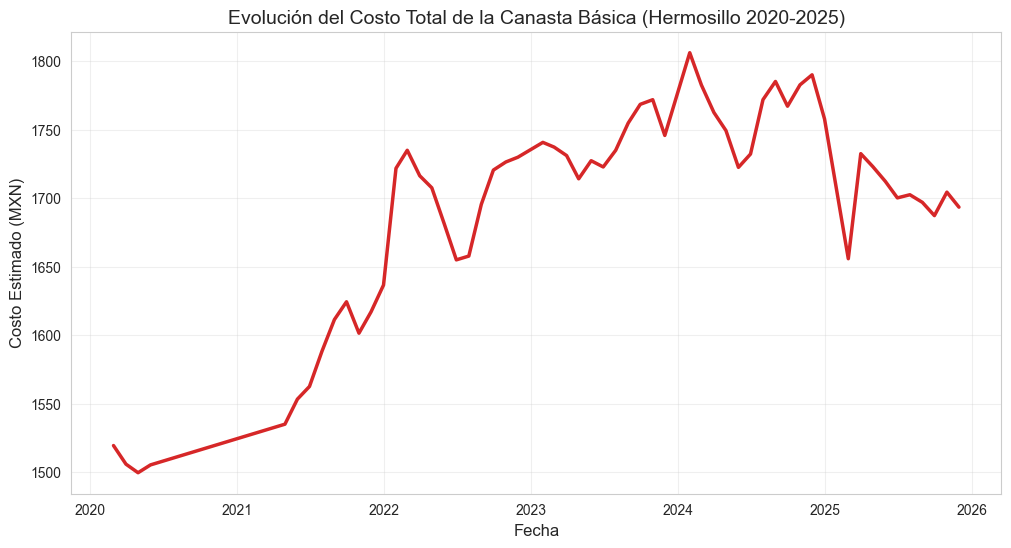

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

mapa_cantidades = {
    "ARROZ": 1.0, "TORTILLA": 4.0, "PAN": 0.68, "PASTA": 0.22, "HARINA": 1.0,
    "RES": 1.0, "CERDO": 1.0, "POLLO": 1.0, "HUEVO": 18.0, "ATUN": 0.28, "SARDINA": 0.425,
    "LECHE": 5.0, "ACEITE": 0.946, "JITOMATE": 1.0, "CEBOLLA": 1.0,
    "CHILE": 1.0, "LIMON": 1.0, "MANZANA": 1.0, "PLATANO": 1.0,
    "PAPA": 1.0, "ZANAHORIA": 1.0, "FRIJOL": 0.9, "AZUCAR": 1.0,
    "JABON": 1.0, "PAPEL": 4.0
}

df_canasta['cantidad_requerida'] = df_canasta['producto_categoria'].map(mapa_cantidades).fillna(1.0)
df_canasta['costo_subtotal'] = df_canasta['precio_unitario'] * df_canasta['cantidad_requerida']


df_mensual = df_canasta.set_index('fecha_registro').pivot_table(
    index=pd.Grouper(freq='M'),
    columns='producto_categoria',
    values='costo_subtotal',
    aggfunc='mean'
)

# Rellenar meses vacíos con el precio del mes anterior
df_mensual = df_mensual.ffill().bfill()

#Calcular el Costo Total de la Canasta (Suma de todas las columnas)
df_mensual['Costo_Total'] = df_mensual.sum(axis=1)

# Graficar
carpeta = "imagenes"
nombre_archivo = "evolucion_costo_canasta.png"

import os
# Crea la carpeta si no existe 
os.makedirs(carpeta, exist_ok=True)

# Ruta completa
ruta_guardado = os.path.join(carpeta, nombre_archivo)


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_mensual, x=df_mensual.index, y='Costo_Total', linewidth=2.5, color='#d62728')

plt.title('Evolución del Costo Total de la Canasta Básica (Hermosillo 2020-2025)', fontsize=14)
plt.ylabel('Costo Estimado (MXN)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.grid(True, alpha=0.3)

plt.savefig(
    ruta_guardado, 
    dpi=300,                
    bbox_inches='tight',    
    transparent=False       
)

print(f"Gráfico guardado exitosamente en: {ruta_guardado}")

# Dato rápido para tus conclusiones
precio_inicial = df_mensual['Costo_Total'].iloc[0]
precio_final = df_mensual['Costo_Total'].iloc[-1]
inflacion = ((precio_final - precio_inicial) / precio_inicial) * 100
print(f"💰 Costo Inicial (2020): ${precio_inicial:.2f}")
print(f"💰 Costo Final (Actual): ${precio_final:.2f}")
print(f"📈 Inflación Acumulada: {inflacion:.2f}%")

Análisis de competencia entre cadenas comerciales
Gráfico guardado exitosamente en: imagenes\comparativa_precios_cadenas.png


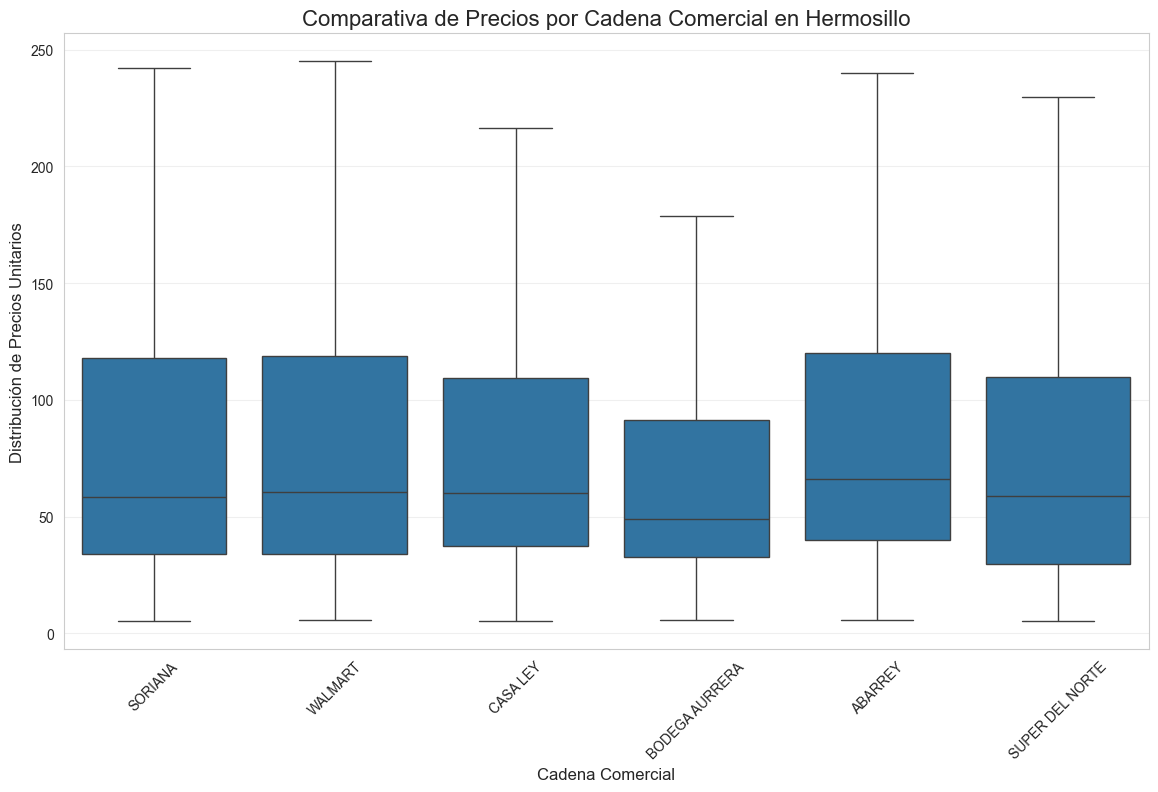


Ranking de Cadenas (De la más barata a la más cara en promedio unitario):
cadena_comercial
BODEGA AURRERA     69.987230
SUPER DEL NORTE    72.908243
CASA LEY           80.502861
SORIANA            80.722262
WALMART            82.686140
ABARREY            84.289275
Name: precio_unitario, dtype: float64


In [174]:
print("Análisis de competencia entre cadenas comerciales")

def limpiar_nombre_tienda(nombre):
    nombre = str(nombre).upper()
    if 'WALMART' in nombre or 'WAL MART' in nombre: return 'WALMART'
    if 'AURRERA' in nombre: return 'BODEGA AURRERA'
    if 'SORIANA' in nombre: return 'SORIANA'
    if 'LEY' in nombre: return 'CASA LEY'
    if 'ABARREY' in nombre: return 'ABARREY'
    if 'SUPER DEL NORTE' in nombre: return 'SUPER DEL NORTE'
    if 'COSTCO' in nombre: return 'COSTCO'
    if 'SAMS' in nombre: return 'SAMS CLUB'
    return 'OTRO' # Tienditas pequeñas o farmacias

df_canasta['cadena_comercial'] = df_canasta['nombre_tienda'].apply(limpiar_nombre_tienda)

# FILTRAR SOLO LAS CADENAS GRANDES
df_competencia = df_canasta[df_canasta['cadena_comercial'] != 'OTRO'].copy()

carpeta = "imagenes"
nombre_archivo = "comparativa_precios_cadenas.png"

# Aseguramos que la carpeta exista (por seguridad, si corres este bloque aislado)
os.makedirs(carpeta, exist_ok=True)

# Ruta completa
ruta_guardado = os.path.join(carpeta, nombre_archivo)

plt.figure(figsize=(14, 8))

sns.boxplot(
    data=df_competencia, 
    x='cadena_comercial', 
    y='precio_unitario',
    showfliers=False 
)

plt.title('Comparativa de Precios por Cadena Comercial en Hermosillo', fontsize=16)
plt.ylabel('Distribución de Precios Unitarios', fontsize=12)
plt.xlabel('Cadena Comercial', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

plt.savefig(
    ruta_guardado, 
    dpi=300, 
    bbox_inches='tight',
    transparent=False
)

print(f"Gráfico guardado exitosamente en: {ruta_guardado}")

plt.show()

# Calculamos el precio promedio de los productos clave en cada tienda
resumen_tiendas = df_competencia.groupby('cadena_comercial')['precio_unitario'].mean().sort_values()
print("\nRanking de Cadenas (De la más barata a la más cara en promedio unitario):")
print(resumen_tiendas)

Análisis de la Volatilidad de los Precios


C:\Users\JAM\AppData\Local\Temp\ipykernel_20052\2192013979.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Gráfico guardado exitosamente en: imagenes\top10_inestabilidad_precios.png


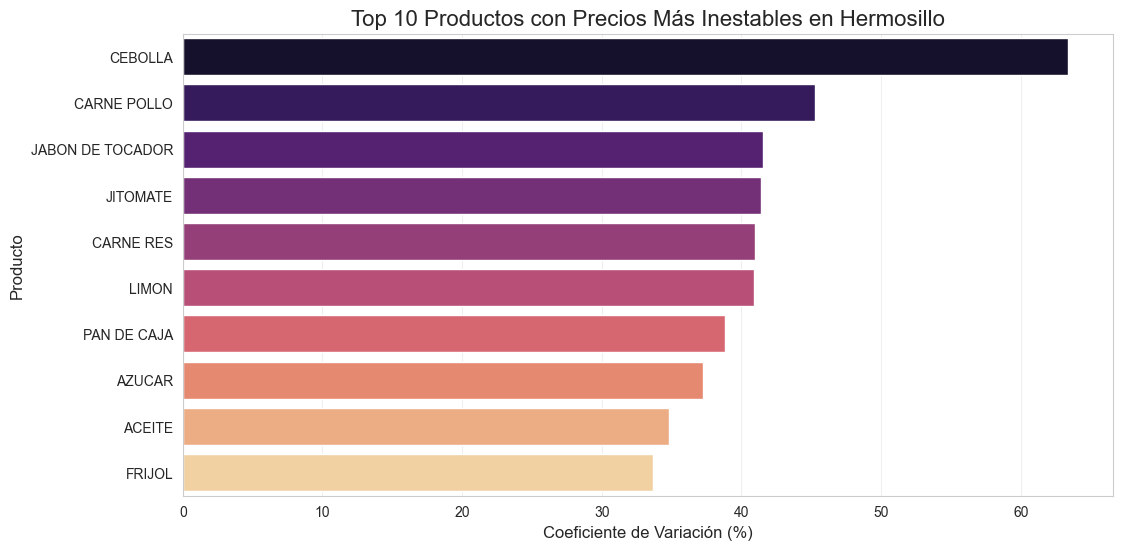

---  DATOS DUROS ---
Los 3 productos más volátiles:
producto_categoria
CEBOLLA             63.410531
CARNE POLLO         45.280224
JABON DE TOCADOR    41.531569
Name: CV_Porcentaje, dtype: float64

Los 3 productos más estables:
producto_categoria
HARINA DE MAIZ     18.115092
PRODUCTO LACTEO     9.212261
HUEVO               4.466055
Name: CV_Porcentaje, dtype: float64


In [175]:
print("Análisis de la Volatilidad de los Precios")

# Estadísticas por producto
stats_productos = df_canasta.groupby('producto_categoria')['precio_unitario'].agg(['mean', 'std'])

# Coeficiente de Variación (CV)
# Fórmula: (Desviación Estándar / Media) * 100
# Interpretación: Un CV alto significa que el precio es muy inestable.
stats_productos['CV_Porcentaje'] = (stats_productos['std'] / stats_productos['mean']) * 100

# Ordenamos del más inestable al más estable
ranking_volatilidad = stats_productos.sort_values(by='CV_Porcentaje', ascending=False)

# 3.(Top 10 Más Volátiles)
carpeta = "imagenes"
nombre_archivo = "top10_inestabilidad_precios.png"

# Asegurar que la carpeta exista
os.makedirs(carpeta, exist_ok=True)
ruta_guardado = os.path.join(carpeta, nombre_archivo)


plt.figure(figsize=(12, 6))


top_volatiles = ranking_volatilidad.head(10)

sns.barplot(
    x=top_volatiles['CV_Porcentaje'], 
    y=top_volatiles.index, 
    palette='magma'
)

plt.title('Top 10 Productos con Precios Más Inestables en Hermosillo', fontsize=16)
plt.xlabel('Coeficiente de Variación (%)', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)


plt.savefig(
    ruta_guardado, 
    dpi=300, 
    bbox_inches='tight', 
    transparent=False
)

print(f"Gráfico guardado exitosamente en: {ruta_guardado}")

plt.show()

print("---  DATOS DUROS ---")
print("Los 3 productos más volátiles:")
print(ranking_volatilidad['CV_Porcentaje'].head(3))
print("\nLos 3 productos más estables:")
print(ranking_volatilidad['CV_Porcentaje'].tail(3))

Calculando el Ahorro Máximo Teórico (La Conclusión Final)...
📊 RESULTADOS DEL PROYECTO (Hermosillo, Sonora)
Costo Canasta 'A Ciegas' (Semanal):   $1,023.76
Costo Canasta 'Optimizada' (Semanal): $428.67
------------------------------
💵 AHORRO SEMANAL: $595.09
💵 AHORRO MENSUAL: $2,380.34
💰 AHORRO ANUAL:   $28,564.12
Gráfico guardado exitosamente en: imagenes\impacto_optimizacion_gasto.png


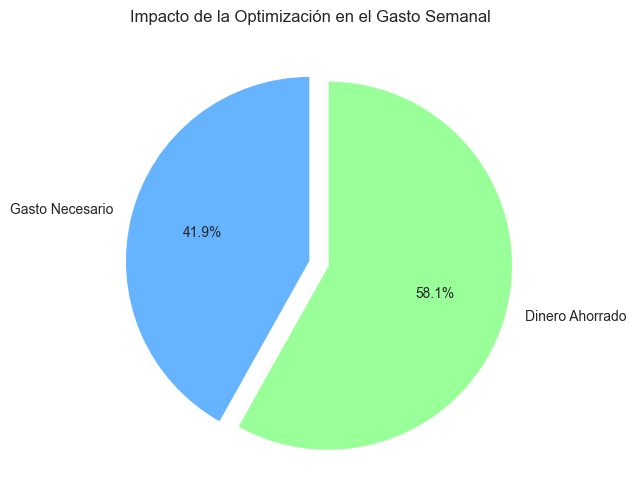

In [176]:
print("Calculando el Ahorro Máximo Teórico (La Conclusión Final)...")

# 1. Filtrar solo datos recientes (Últimos 6 meses para que sea actual)
fecha_corte = df_canasta['fecha_registro'].max() - pd.Timedelta(days=180)
df_actual = df_canasta[df_canasta['fecha_registro'] > fecha_corte].copy()

# 2. Agrupar por producto y obtener el precio Promedio vs Mínimo
comparativa = df_actual.groupby('producto_categoria').agg({
    'precio_unitario': ['mean', 'min'],
    'cantidad_requerida': 'first' # La cantidad es la misma siempre
})

# Aplanamos las columnas para manejarlas fácil
comparativa.columns = ['precio_promedio', 'precio_minimo', 'cantidad']

# 3. Calcular el costo total de la canasta en ambos escenarios
comparativa['gasto_promedio'] = comparativa['precio_promedio'] * comparativa['cantidad']
comparativa['gasto_inteligente'] = comparativa['precio_minimo'] * comparativa['cantidad']

total_promedio = comparativa['gasto_promedio'].sum()
total_inteligente = comparativa['gasto_inteligente'].sum()
ahorro_semanal = total_promedio - total_inteligente
ahorro_mensual = ahorro_semanal * 4
ahorro_anual = ahorro_mensual * 12

# 4. RESULTADOS FINALES
print("="*60)
print(f"📊 RESULTADOS DEL PROYECTO (Hermosillo, Sonora)")
print("="*60)
print(f"Costo Canasta 'A Ciegas' (Semanal):   ${total_promedio:,.2f}")
print(f"Costo Canasta 'Optimizada' (Semanal): ${total_inteligente:,.2f}")
print("-" * 30)
print(f"💵 AHORRO SEMANAL: ${ahorro_semanal:,.2f}")
print(f"💵 AHORRO MENSUAL: ${ahorro_mensual:,.2f}")
print(f"💰 AHORRO ANUAL:   ${ahorro_anual:,.2f}")
print("="*60)

# Gráfica del Ahorro
carpeta = "imagenes"
nombre_archivo = "impacto_optimizacion_gasto.png"

os.makedirs(carpeta, exist_ok=True)
ruta_guardado = os.path.join(carpeta, nombre_archivo)


plt.figure(figsize=(6, 6))

plt.pie(
    [total_inteligente, ahorro_semanal], 
    labels=['Gasto Necesario', 'Dinero Ahorrado'], 
    autopct='%1.1f%%', 
    colors=['#66b3ff', '#99ff99'],
    explode=(0, 0.1), # Separa la rebanada de ahorro para resaltarla
    startangle=90
)

plt.title('Impacto de la Optimización en el Gasto Semanal')

plt.savefig(
    ruta_guardado, 
    dpi=300, 
    bbox_inches='tight', 
    transparent=False
)

print(f"Gráfico guardado exitosamente en: {ruta_guardado}")

plt.show()

El Supermercado Ganador (Ticket Promedio Total)
Gráfico guardado exitosamente en: imagenes\ranking_costo_super.png


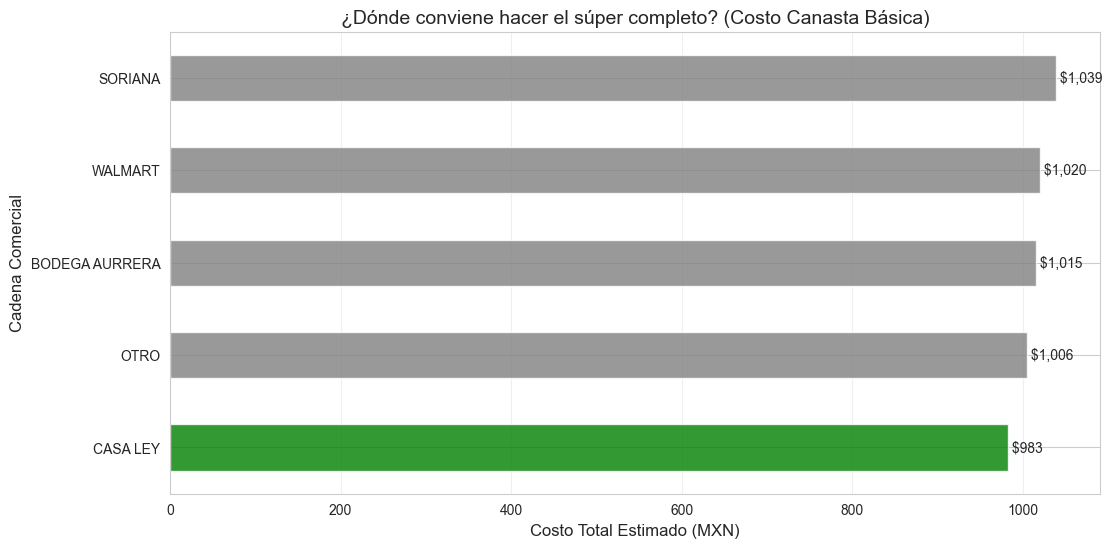

GANADOR: CASA LEY con un costo de $983.02


In [177]:
print("El Supermercado Ganador (Ticket Promedio Total)")

# Datos recientes últimos 90 días
fecha_corte = df_canasta['fecha_registro'].max() - pd.Timedelta(days=90) # Últimos 3 meses
df_reciente = df_canasta[df_canasta['fecha_registro'] > fecha_corte].copy()

# Calculo del costo promedio de CADA producto en CADA cadena
precios_por_cadena = df_reciente.pivot_table(
    index='cadena_comercial', 
    columns='producto_categoria', 
    values='precio_unitario', 
    aggfunc='mean'
)

precios_por_cadena = precios_por_cadena.fillna(df_reciente.groupby('producto_categoria')['precio_unitario'].mean())

# Ticket Total por Cadena 
costos_totales = pd.Series(dtype=float)

for cadena in precios_por_cadena.index:
    costo_ticket = 0
    for producto, precio in precios_por_cadena.loc[cadena].items():
        # Buscando en las cantidades requeridas de la canasta básica
        cantidad = mapa_cantidades.get(producto, 1.0)
        costo_ticket += (precio * cantidad)
    
    costos_totales[cadena] = costo_ticket

ranking_tiendas = costos_totales.sort_values()

carpeta = "imagenes"
nombre_archivo = "ranking_costo_super.png"

# Asegurar que la carpeta exista
os.makedirs(carpeta, exist_ok=True)
ruta_guardado = os.path.join(carpeta, nombre_archivo)


plt.figure(figsize=(12, 6))

colores = ['green' if x == ranking_tiendas.min() else 'grey' for x in ranking_tiendas]

ranking_tiendas.plot(kind='barh', color=colores, alpha=0.8)

plt.title('¿Dónde conviene hacer el súper completo? (Costo Canasta Básica)', fontsize=14)
plt.xlabel('Costo Total Estimado (MXN)', fontsize=12)
plt.ylabel('Cadena Comercial', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)

for index, value in enumerate(ranking_tiendas):
    plt.text(value, index, f' ${value:,.0f}', va='center')

plt.savefig(
    ruta_guardado, 
    dpi=300, 
    bbox_inches='tight', 
    transparent=False
)

print(f"Gráfico guardado exitosamente en: {ruta_guardado}")

plt.show()

print(f"GANADOR: {ranking_tiendas.index[0]} con un costo de ${ranking_tiendas.iloc[0]:,.2f}")